# TP Machine Learning - Industrie Sidérurgique
## Partie 4 : Détection d'anomalies par Deep Learning

Dans cette partie, nous allons utiliser des réseaux de neurones convolutifs (CNN) avec PyTorch
pour détecter des anomalies dans des images industrielles, en utilisant le dataset MVTec AD.

### Objectifs :
- Comprendre les principes de la détection d'anomalies par Deep Learning
- Implémenter un modèle CNN avec PyTorch
- Évaluer et visualiser les résultats

### Méthodes abordées :
- Autoencodeurs convolutifs avec PyTorch
- Transfer Learning
- Métriques de détection d'anomalies

⚠️ **Important** : Avant de commencer, activez le GPU :
1. Menu "Runtime" > "Change runtime type"
2. Sélectionnez "T4 GPU" dans le menu déroulant "Hardware accelerator"
3. Cliquez sur "Save"

In [1]:
# Import des packages nécessaires
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.distributions as dist

# Vérification du GPU
print("GPU disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))

# Configuration
sns.set_theme(style='whitegrid')
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

GPU disponible : True
Nom du GPU : Tesla T4
Utilisation de : cuda


### 1. Chargement et préparation des données MVTec AD (Bottle dataset)

Le dataset MVTec AD contient des images industrielles de différents objets,
avec des exemples normaux et anormaux.

❓ Questions sur les données :
- Pourquoi n'utiliser que des images "normales" pour l'entraînement ?
- Comment cela reflète-t-il la réalité industrielle ?
- Quel est l'intérêt de l'augmentation de données dans ce contexte ?

In [2]:
# Création du dossier pour le dataset
!mkdir -p mvtec_data

# Téléchargement uniquement du dataset bottle
!wget -P mvtec_data https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/bottle.tar.xz
!cd mvtec_data && tar -xf bottle.tar.xz

# Vérification de la structure du dataset
print("\nStructure du dataset :")
!ls -R mvtec_data/bottle | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//  /g' -e 's/^/  /'

# Création d'un Dataset personnalisé
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Définition des transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Réduction de 256x256 à 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Réduction de 256x256 à 128x128
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3)
])

# Création des datasets avec les nouveaux chemins
train_dataset = MVTecDataset('mvtec_data/bottle/train/good', transform=train_transform)
test_normal_dataset = MVTecDataset('mvtec_data/bottle/test/good', transform=test_transform)
# /!\ Complétez les '...' pour créer un test_anomaly_dataset qui se source dans les images mvtec_data/bottle/test/broken_large /!\
test_anomaly_dataset = MVTecDataset('mvtec_data/bottle/test/broken_large', transform=test_transform)

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Batch size de 32 à 16
test_normal_loader = DataLoader(test_normal_dataset, batch_size=16, shuffle=False)
test_anomaly_loader = DataLoader(test_anomaly_dataset, batch_size=16, shuffle=False)

print("\nNombre d'images :")
print(f"Training (normal) : {len(train_dataset)}")
print(f"Test (normal) : {len(test_normal_dataset)}")
print(f"Test (anomalies) : {len(test_anomaly_dataset)}")

--2025-05-28 14:09:41--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/bottle.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5264982680 (4.9G) [application/x-xz]
Saving to: ‘mvtec_data/bottle.tar.xz’

bottle.tar.xz       100%[===================>]   4.90G   105MB/s    in 77s     

2025-05-28 14:10:58 (65.2 MB/s) - ‘mvtec_data/bottle.tar.xz’ saved [5264982680/5264982680]


Structure du dataset :
    bottle
      ground_truth
        broken_large
        broken_small
        contamination
      test
        broken_large
        broken_small
        contamination
        good
      train
        good

Nombre d'images :
Training (normal) : 209
Test (normal) : 20
Test (anomalies) : 20


### 2. Création du modèle Autoencoder avec PyTorch

❓ Questions sur l'architecture :
- Pourquoi choisir une architecture encodeur-décodeur ?
- Que représente l'espace latent dans notre contexte industriel ?
- Comment le bottleneck force-t-il l'apprentissage de caractéristiques pertinentes ?

In [4]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()

        # Réduction du nombre de filtres
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # 64 -> 32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 128 -> 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 256 -> 128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),  # 512 -> 256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Decoder (mise à jour des dimensions en conséquence)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoding avec skip connections
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return d1, b

# Loss améliorée avec composante structurelle
class EnhancedLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super(EnhancedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()

    def forward(self, output, target, encoded_output, encoded_target):
        # MSE pour la reconstruction globale
        mse_loss = self.mse(output, target)

        # L1 pour les détails fins
        l1_loss = self.l1(output, target)

        # MSE sur l'espace latent
        # /!\ Complétez les '...' pour créer une feature loss qui est une mse entre encoded_output et encoded_target /!\
        feature_loss = self.mse(encoded_output, encoded_target)

        # Combinaison des losses
        total_loss = self.alpha * (0.5 * mse_loss + 0.5 * l1_loss) + self.beta * feature_loss
        return total_loss

# Mise à jour des datasets avec les nouvelles transformations
train_dataset = MVTecDataset('mvtec_data/bottle/train/good', transform=train_transform)
test_normal_dataset = MVTecDataset('mvtec_data/bottle/test/good', transform=test_transform)
test_anomaly_dataset = MVTecDataset('mvtec_data/bottle/test/broken_large', transform=test_transform)

# Création et déplacement du modèle sur le device approprié
model = ImprovedAutoencoder().to(device)
criterion = EnhancedLoss(alpha=0.7, beta=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [5]:
# Fonction d'entraînement améliorée
def train_improved_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass avec encoded features
        reconstructed, encoded = model(batch)
        with torch.no_grad():
            _, target_encoded = model(batch)

        # Calcul de la loss combinée
        loss = criterion(reconstructed, batch, encoded, target_encoded.detach())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Libération explicite de la mémoire
        del reconstructed, encoded, target_encoded
        torch.cuda.empty_cache()

    return total_loss / len(dataloader)

# Entraînement avec early stopping
n_epochs = 100
best_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []

for epoch in range(n_epochs):
    loss = train_improved_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)

    # Learning rate scheduling
    scheduler.step(loss)

    # Early stopping
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.4f}')

# Chargement du meilleur modèle pour l'évaluation
model.load_state_dict(torch.load('best_autoencoder.pth'))

Epoch [5/100], Loss: 0.0130
Epoch [10/100], Loss: 0.0057
Epoch [15/100], Loss: 0.0042
Epoch [20/100], Loss: 0.0049
Epoch [25/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0037
Epoch [35/100], Loss: 0.0032
Epoch [40/100], Loss: 0.0027
Epoch [45/100], Loss: 0.0032
Epoch [50/100], Loss: 0.0029
Early stopping at epoch 52


<All keys matched successfully>

### 3. Évaluation et détection des anomalies

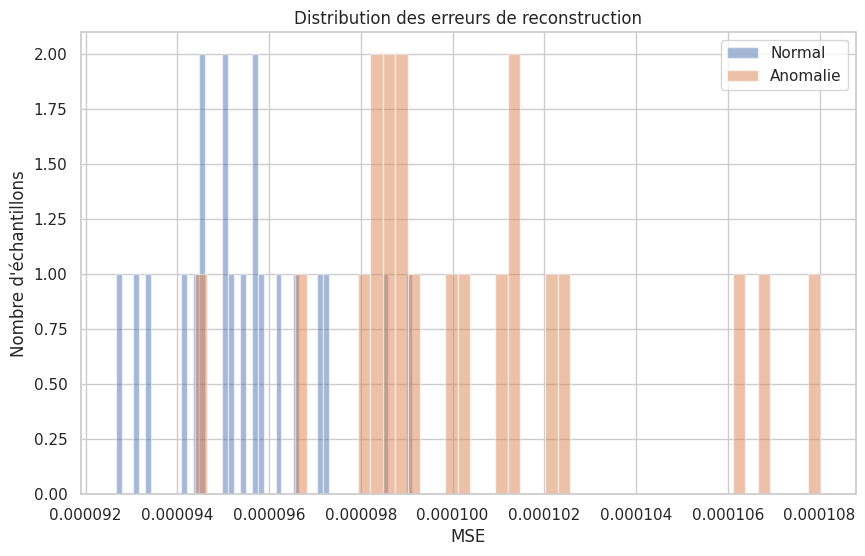

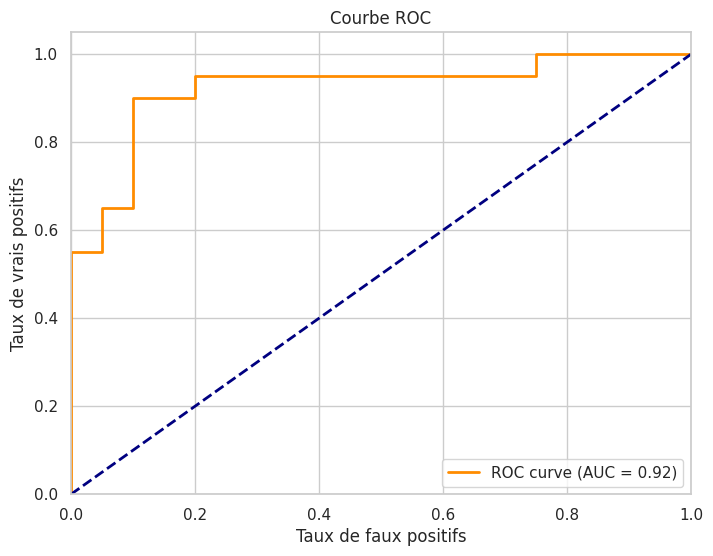

In [6]:
@torch.no_grad()
def compute_reconstruction_error(model, dataloader):
    model.eval()
    errors = []

    for batch in dataloader:
        batch = batch.to(device)
        reconstructed, encoded = model(batch)  # Déballage du tuple
        error = torch.mean((batch - reconstructed) ** 2, dim=(1,2,3))
        errors.extend(error.cpu().numpy())

    return np.array(errors)

# Calcul des erreurs de reconstruction
normal_errors = compute_reconstruction_error(model, test_normal_loader)
anomaly_errors = compute_reconstruction_error(model, test_anomaly_loader)

# Visualisation de la distribution des erreurs
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomalie')
plt.title('Distribution des erreurs de reconstruction')
plt.xlabel('MSE')
plt.ylabel('Nombre d\'échantillons')
plt.legend()
plt.show()

# Calcul et affichage de la courbe ROC
y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
# /!\ Complétez les '...' pour créer y_scores représentant, composé de la concaténation des erreurs normales (normal_errors) et des anomalies (anomaly_errors) /!\
y_scores = np.concatenate([normal_errors, anomaly_errors])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### 4. Visualisation des résultats

Exemples normaux :


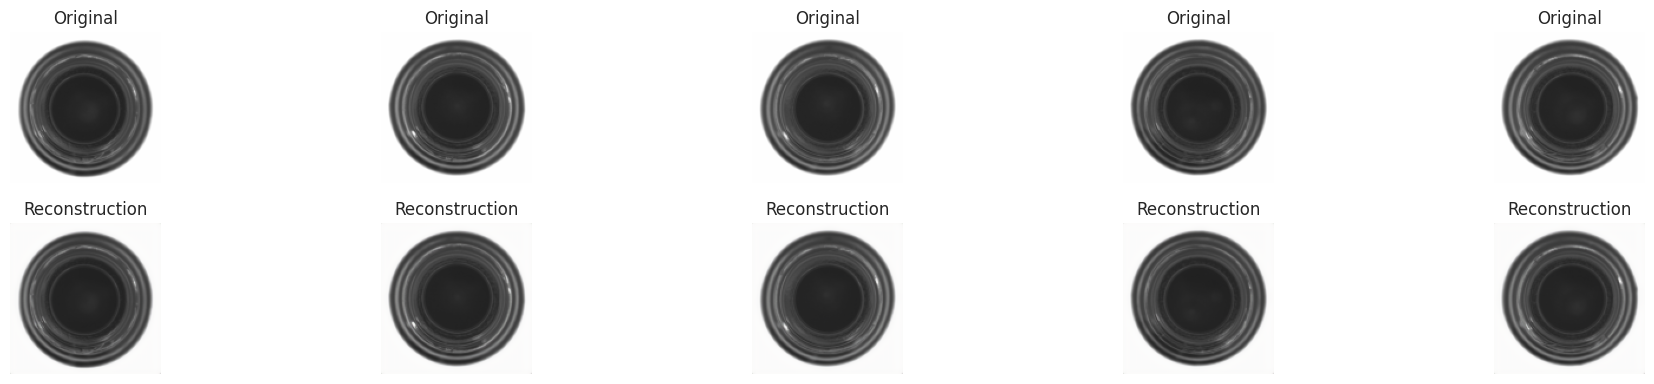


Exemples avec anomalies :


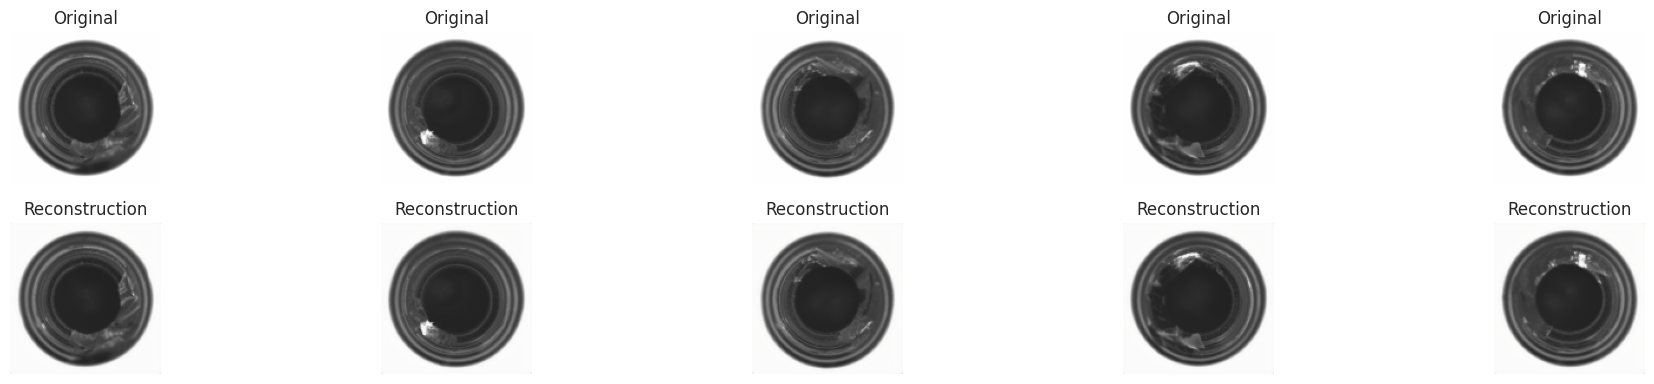

In [7]:
@torch.no_grad()
def plot_results(model, dataloader, n=5):
    model.eval()

    # Récupération d'un batch
    batch = next(iter(dataloader))
    batch = batch[:n].to(device)
    reconstructed, _ = model(batch)

    # Conversion pour affichage
    batch = batch.cpu()
    reconstructed = reconstructed.cpu()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        img = batch[i].permute(1, 2, 0).numpy()
        plt.imshow(img, cmap='gray')  # Utiliser cmap='gray' pour les images en niveaux de gris
        plt.title('Original')
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, n, i + n + 1)
        img = reconstructed[i].permute(1, 2, 0).numpy()
        plt.imshow(img, cmap='gray')  # Utiliser cmap='gray' pour les images en niveaux de gris
        # /!\ Complétez les '...' pour ajouter le titre 'Reconstruction' au graphe /!\
        plt.title('Reconstruction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualisation des résultats
print("Exemples normaux :")
plot_results(model, test_normal_loader)

print("\nExemples avec anomalies :")
plot_results(model, test_anomaly_loader)

❓ Questions sur l'autoencoder classique :

- Pourquoi les reconstructions sont-elles presque identiques aux images d'origine ?
- Comment expliquer la faible différence entre les erreurs de reconstruction des images normales et anormales ?
- L'autoencoder a-t-il vraiment appris les caractéristiques "normales" des bouteilles ?
- Est-ce que cette "trop bonne" reconstruction est souhaitable pour la détection d'anomalies ?
- Que se passe-t-il si l'autoencoder apprend à simplement "recopier" l'entrée ?

### 5. Amélioration avec un Variational Autoencoder (VAE)

Pour améliorer la détection d'anomalies, nous allons utiliser un VAE qui devrait :
- Mieux régulariser l'espace latent
- Apprendre une distribution plus robuste des images normales
- Mieux "réparer" les anomalies dans les reconstructions

In [8]:
vae_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x)
])

# /!\ Complétez les '...' pour transformer l'image de départ en résolution 128x128n pendant la transformation /!\
vae_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x)
])

# Création de nouveaux datasets pour le VAE
vae_train_dataset = MVTecDataset('mvtec_data/bottle/train/good', transform=vae_train_transform)
vae_test_normal_dataset = MVTecDataset('mvtec_data/bottle/test/good', transform=vae_test_transform)
vae_test_anomaly_dataset = MVTecDataset('mvtec_data/bottle/test/broken_large', transform=vae_test_transform)

# Création des dataloaders pour le VAE
vae_train_loader = DataLoader(vae_train_dataset, batch_size=16, shuffle=True)
vae_test_normal_loader = DataLoader(vae_test_normal_dataset, batch_size=16, shuffle=False)
vae_test_anomaly_loader = DataLoader(vae_test_anomaly_dataset, batch_size=16, shuffle=False)

# Définition du VAE
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):  # Dimension latente réduite
        super().__init__()

        # Encoder inspiré de l'autoencoder qui fonctionnait bien
        self.encoder = nn.Sequential(
            # Premier bloc
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Deuxième bloc
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Troisième bloc
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Projections mu et logvar
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_var = nn.Linear(128 * 16 * 16, latent_dim)

        # Decoder symétrique
        self.decoder_input = nn.Linear(latent_dim, 128 * 16 * 16)

        self.decoder = nn.Sequential(
            # Premier bloc
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Deuxième bloc
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Troisième bloc
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Couche finale
            nn.Conv2d(32, 3, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_var(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(z.size(0), 128, 16, 16)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function avec un très faible poids KL
class VAELoss(nn.Module):
    def __init__(self, kld_weight=0.0001):  # Poids KL très faible
        super().__init__()
        self.kld_weight = kld_weight

    def forward(self, recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.kld_weight * kld_loss

In [9]:
# Paramètres d'entraînement
vae_model = VariationalAutoencoder().to(device)
vae_criterion = VAELoss()
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.0001)

# Fonction d'entraînement du VAE
def train_vae_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(batch)
        loss = criterion(recon_batch, batch, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Entraînement du VAE
print("Début de l'entraînement du VAE...")
n_epochs = 100
best_loss = float('inf')
vae_losses = []

for epoch in range(n_epochs):
    loss = train_vae_epoch(vae_model, vae_train_loader, vae_criterion, vae_optimizer)
    vae_losses.append(loss)

    if loss < best_loss:
        best_loss = loss
        torch.save(vae_model.state_dict(), 'best_vae.pth')

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.4f}')

Début de l'entraînement du VAE...
Epoch [10/100], Loss: 0.0363
Epoch [20/100], Loss: 0.0240
Epoch [30/100], Loss: 0.0165
Epoch [40/100], Loss: 0.0129
Epoch [50/100], Loss: 0.0093
Epoch [60/100], Loss: 0.0079
Epoch [70/100], Loss: 0.0065
Epoch [80/100], Loss: 0.0053
Epoch [90/100], Loss: 0.0051
Epoch [100/100], Loss: 0.0039



Résultats du VAE sur les images normales :


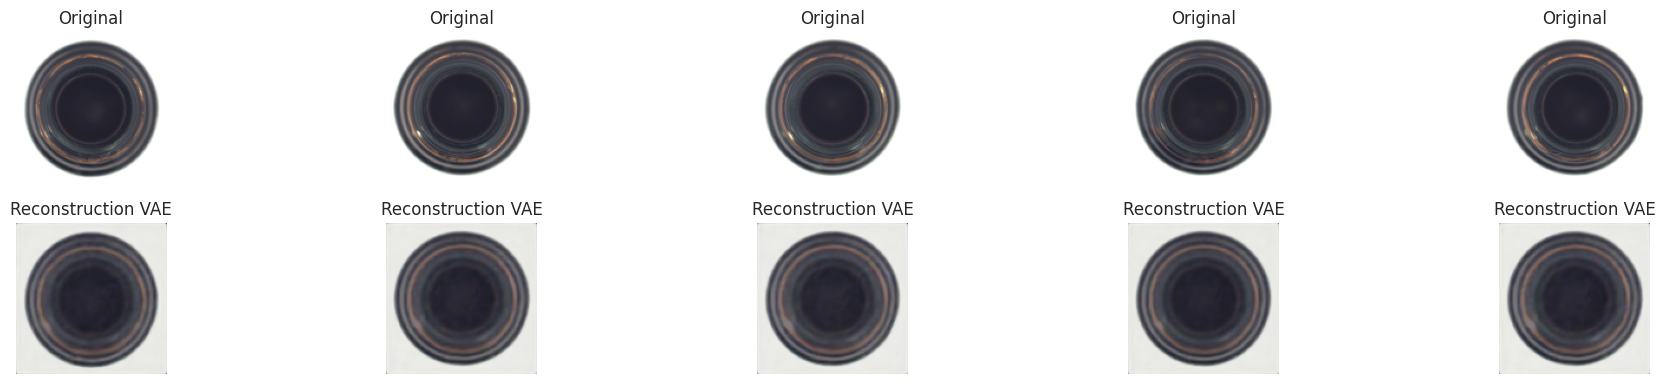


Résultats du VAE sur les images avec anomalies :


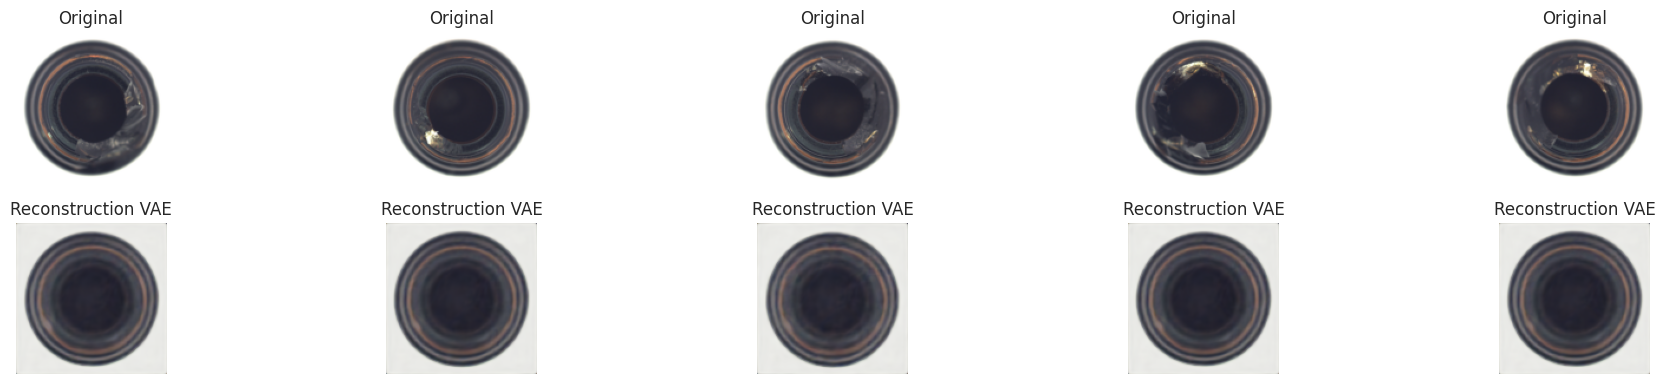

In [10]:
# Visualisation des résultats du VAE
@torch.no_grad()
def plot_vae_results(model, dataloader, n=5):
    model.eval()
    batch = next(iter(dataloader))
    batch = batch[:n].to(device)
    recon, _, _ = model(batch)

    batch = batch.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(batch[i].permute(1, 2, 0), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, n, i + n + 1)
        plt.imshow(recon[i].permute(1, 2, 0), cmap='gray')
        plt.title('Reconstruction VAE')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nRésultats du VAE sur les images normales :")
plot_vae_results(vae_model, vae_test_normal_loader)

print("\nRésultats du VAE sur les images avec anomalies :")
# /!\ Complétez les '...' pour afficher les images d'entrée et reconstruites (vae_test_anomaly_loader), via le variational auto-encoder  /!\
plot_vae_results(vae_model, vae_test_anomaly_loader)


❓ Questions sur les avantages du VAE :
- Pourquoi les reconstructions du VAE sont-elles plus "floues" ?
- En quoi ce "flou" est-il en réalité un avantage pour la détection d'anomalies ?
- Comment le VAE gère-t-il différemment les caractéristiques inhabituelles ?

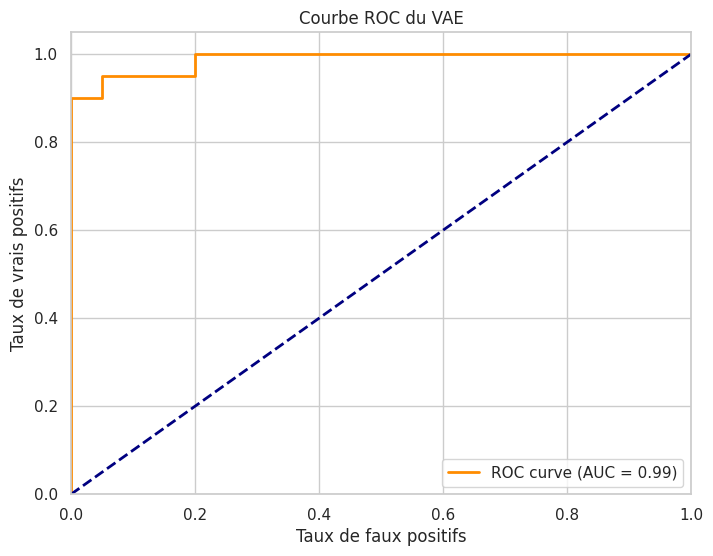

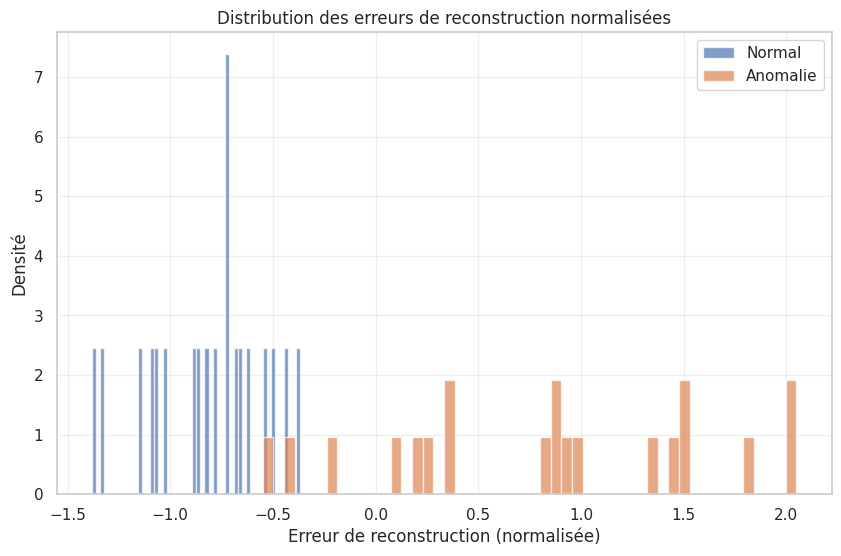

In [11]:
@torch.no_grad()
def evaluate_vae(model, normal_loader, anomaly_loader):
    model.eval()

    normal_errors = []
    anomaly_errors = []

    # Pour les images normales
    for batch in normal_loader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        # Erreur de reconstruction pixel par pixel
        recon_error = F.mse_loss(recon, batch, reduction='none')
        # Moyenne sur les canaux uniquement (garde les dimensions spatiales)
        recon_error = recon_error.mean(dim=1)
        # Maximum local pour détecter les anomalies locales
        recon_error = F.max_pool2d(recon_error, kernel_size=3, stride=1, padding=1)
        # Moyenne sur l'image
        recon_error = recon_error.mean(dim=(1,2))

        normal_errors.extend(recon_error.cpu().numpy())

    # Pour les images avec anomalies
    for batch in anomaly_loader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        recon_error = F.mse_loss(recon, batch, reduction='none')
        recon_error = recon_error.mean(dim=1)
        recon_error = F.max_pool2d(recon_error, kernel_size=3, stride=1, padding=1)
        recon_error = recon_error.mean(dim=(1,2))

        anomaly_errors.extend(recon_error.cpu().numpy())

    # Normalisation des erreurs
    all_errors = np.concatenate([normal_errors, anomaly_errors])
    error_mean = np.mean(all_errors)
    error_std = np.std(all_errors)
    normal_errors = (normal_errors - error_mean) / error_std
    anomaly_errors = (anomaly_errors - error_mean) / error_std

    # Calcul des métriques
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    y_scores = np.concatenate([normal_errors, anomaly_errors])

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    return {
        'normal_errors': normal_errors,
        'anomaly_errors': anomaly_errors,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# Visualisation améliorée des résultats
metrics = evaluate_vae(vae_model, vae_test_normal_loader, vae_test_anomaly_loader)

# Courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(metrics['FPR'], metrics['TPR'], color='darkorange', lw=2,
         label=f'ROC curve (AUC = {metrics["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC du VAE')
plt.legend(loc="lower right")
plt.show()

# Distribution des erreurs
plt.figure(figsize=(10, 6))
plt.hist(metrics['normal_errors'], bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(metrics['anomaly_errors'], bins=50, alpha=0.7, label='Anomalie', density=True)
plt.title('Distribution des erreurs de reconstruction normalisées')
plt.xlabel('Erreur de reconstruction (normalisée)')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, alpha=0.3)
# /!\ Complétez les '...' pour afficher le graphe /!\
plt.show()

### Analyse de la Reconstruction des Anomalies

❓ Questions d'approfondissement :
- Comment le VAE "force-t-il" l'apprentissage de caractéristiques utiles ?
- Pourquoi la contrainte de distribution normale dans l'espace latent est-elle importante ?
- Comment pourrait-on encore améliorer la détection d'anomalies ?

### Conclusion et perspectives
❓ Questions finales :
- Quel modèle choisir pour une application industrielle réelle ?
- Comment adapter ces modèles à d'autres types d'anomalies ?
- Quelles améliorations pourrait-on encore apporter ?